In [16]:
import logging
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [17]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

#### load datasets

In [18]:
dataset_dir = '../data/pytorch_datasets/pdac_v3/'

In [19]:
def get_n_voxels(padded_voxel_idxs):
    idx = padded_voxel_idxs.flip((0,)).nonzero()[0].item()
    return len(padded_voxel_idxs[:-idx])

In [20]:
class DirectorySTDataset(Dataset):
    def __init__(self, directory, normalize=True):
        super().__init__()
        self.dir = directory
        self.fps = [os.path.join(self.dir, fp) for fp in os.listdir(self.dir) if fp[-3:]=='.pt']
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
        
    def __len__(self):
        return len(self.fps)

    def __getitem__(self, idx):
        
        fp = self.fps[idx]
        obj = torch.load(fp)

        return {
            'he': self.normalize(TF.convert_image_dtype(obj['he'], dtype=torch.float32)),
            'he_orig': TF.convert_image_dtype(obj['he'], dtype=torch.float32),
            'masks': obj['masks'],
            'voxel_idxs': obj['voxel_idxs'],
            'exp': obj['exp'].to(torch.float32),
            'n_voxels': get_n_voxels(obj['voxel_idxs']),
            'b': torch.tensor([1.])
        }

In [22]:
train_ds = DirectorySTDataset(os.path.join(dataset_dir, 'train'))
len(train_ds)

7880

In [23]:
val_ds = DirectorySTDataset(os.path.join(dataset_dir, 'val'))
len(val_ds)

3234

In [26]:
train_adata = sc.read_h5ad(os.path.join(dataset_dir, 'train', 'adata.h5ad'))
train_adata

AnnData object with n_obs × n_vars = 3940 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [27]:
val_adata = sc.read_h5ad(os.path.join(dataset_dir, 'val', 'adata.h5ad'))
val_adata

AnnData object with n_obs × n_vars = 3234 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [28]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [32]:
%%time
batch = next(iter(train_dl))

CPU times: user 14 s, sys: 373 ms, total: 14.4 s
Wall time: 367 ms


###### data inspection

In [33]:
def cte(padded_exp, masks, n_voxels):
    tile = torch.zeros((masks.shape[1], masks.shape[2], padded_exp.shape[1]))
    for exp, m in list(zip(padded_exp, masks))[:n_voxels]:
        tile[m==1] = exp
    return tile

In [71]:
i = 166
# i = 144

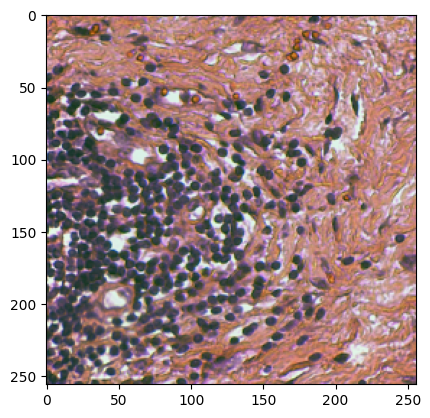

In [72]:
img = rearrange(train_ds[i]['he'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

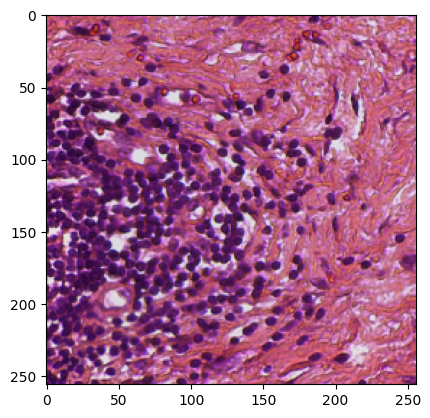

In [73]:
img = rearrange(train_ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

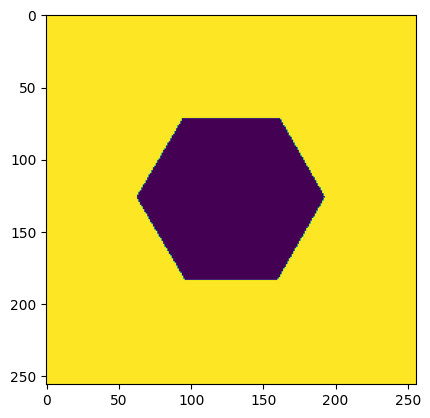

In [74]:
plt.imshow(torch.sum(train_ds[i]['masks'], dim=0))

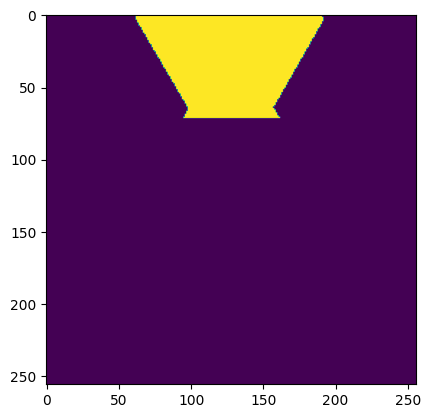

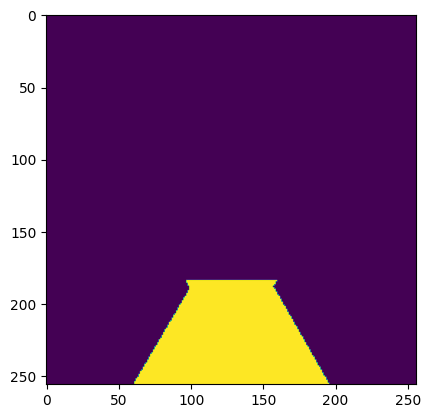

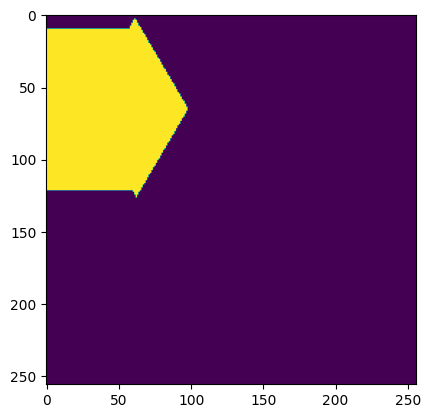

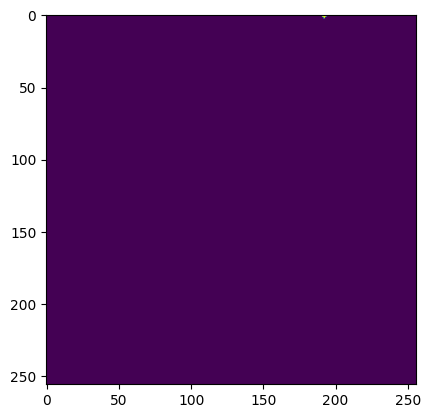

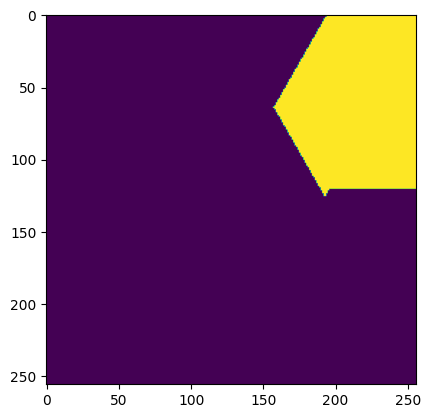

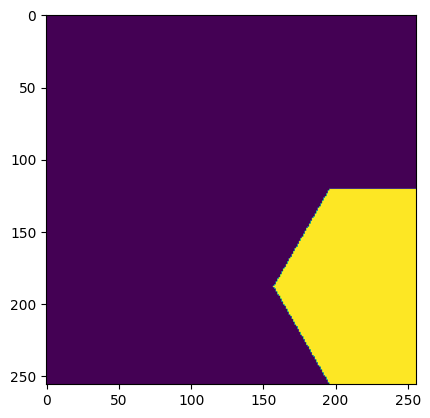

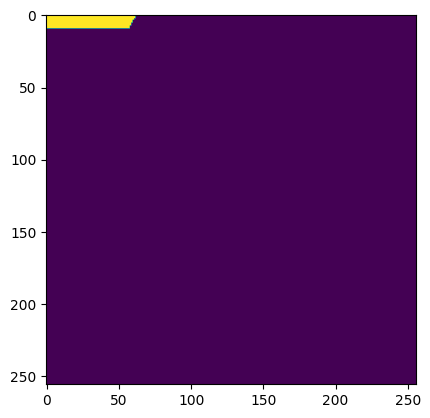

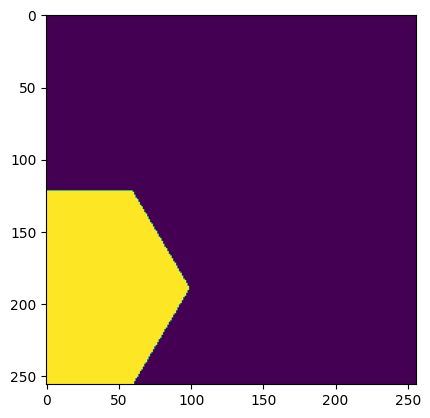

In [81]:
for j in range(train_ds[i]['n_voxels']):
    plt.imshow(train_ds[i]['masks'][j])
    plt.show()

In [75]:
torch.sum(train_ds[i]['masks'], dim=(-1, -2))

tensor([ 6718,  6796,  9235,     7,  9828, 10685,   602, 10695,     0,     0,
            0,     0,     0,     0,     0,     0])

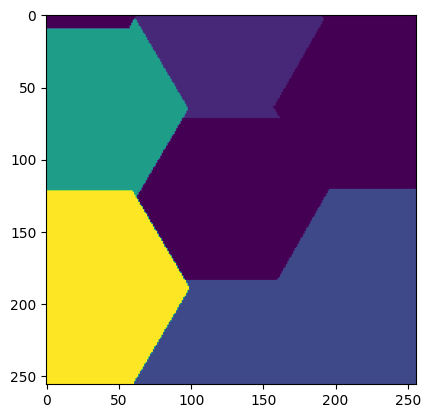

In [76]:
gene = 'IL7R'
recon = cte(train_ds[i]['exp'], train_ds[i]['masks'], train_ds[i]['n_voxels'])
plt.imshow(recon[:, :, train_adata.var.index.to_list().index(gene)])

In [77]:
train_ds[i]['exp']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [2., 0., 0.,  ..., 2., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [78]:
train_ds[i]['voxel_idxs']

tensor([1356, 2060, 2132, 2632, 2886, 2900, 3900, 3910,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=torch.int16)

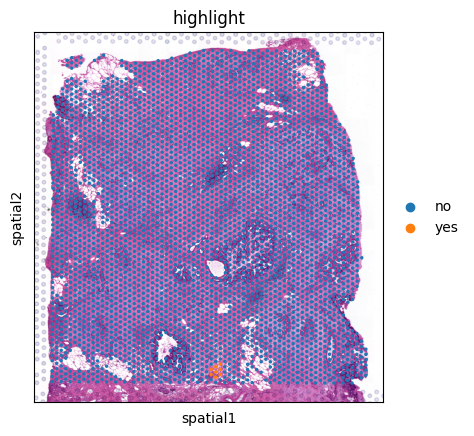

In [53]:
pool = set(train_ds[i]['voxel_idxs'][:train_ds[i]['n_voxels']].detach().numpy())
train_adata.obs['highlight'] = ['yes' if i in pool else 'no'
                               for i in train_adata.obs['spot_index']]
sc.pl.spatial(train_adata, color='highlight')

In [54]:
i = 8

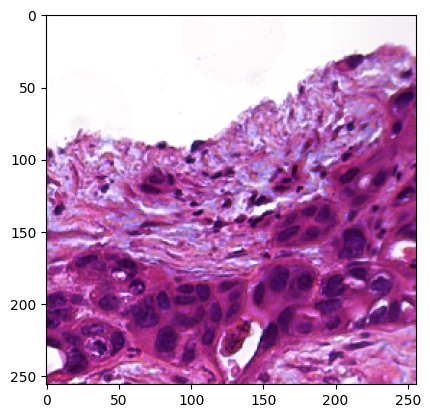

In [55]:
img = rearrange(val_ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

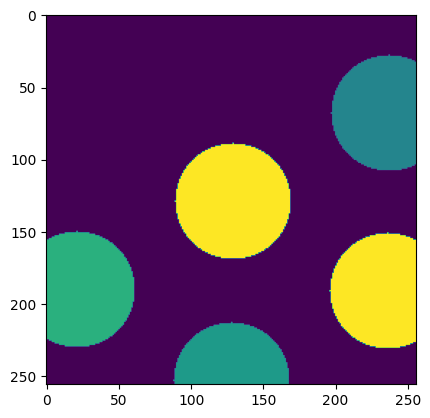

In [56]:
gene = 'EPCAM'
recon = cte(val_ds[i]['exp'], val_ds[i]['masks'], val_ds[i]['n_voxels'])
plt.imshow(recon[:, :, val_adata.var.index.to_list().index(gene)])

In [ ]:
pool = set(val_ds[i]['voxel_idxs'][:val_ds[i]['n_voxels']].detach().numpy())
val_adata.obs['highlight'] = ['yes' if i in pool else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

#### model

In [2]:
from typing import Optional, Tuple, Union
from diffusers.models.unet_blocks import UNetMidBlock2D, get_down_block, get_up_block
from diffusers.models.vae import Encoder, Decoder, DiagonalGaussianDistribution, AutoencoderKLOutput, DecoderOutput

In [15]:

"""modified from diffusers kl autoencoder"""
class AutoencoderKL(nn.Module):
    r"""Variational Autoencoder (VAE) model with KL loss from the paper Auto-Encoding Variational Bayes by Diederik P. Kingma
    and Max Welling.
    This model inherits from [`ModelMixin`]. Check the superclass documentation for the generic methods the library
    implements for all the model (such as downloading or saving, etc.)
    Parameters:
        in_channels (int, *optional*, defaults to 3): Number of channels in the input image.
        out_channels (int,  *optional*, defaults to 3): Number of channels in the output.
        down_block_types (`Tuple[str]`, *optional*, defaults to :
            obj:`("DownEncoderBlock2D",)`): Tuple of downsample block types.
        up_block_types (`Tuple[str]`, *optional*, defaults to :
            obj:`("UpDecoderBlock2D",)`): Tuple of upsample block types.
        block_out_channels (`Tuple[int]`, *optional*, defaults to :
            obj:`(64,)`): Tuple of block output channels.
        act_fn (`str`, *optional*, defaults to `"silu"`): The activation function to use.
        latent_channels (`int`, *optional*, defaults to `4`): Number of channels in the latent space.
        sample_size (`int`, *optional*, defaults to `32`): TODO
    """
    def __init__(
        self,
        n_genes,
        tile_resolution = 16,
        n_metagenes = 20,
        in_channels = 3,
        out_channels = 64,
        down_block_types = ("DownEncoderBlock2D",),
        up_block_types = ("UpDecoderBlock2D",),
        block_out_channels = (64,),
        layers_per_block = 1,
        act_fn = "silu",
        latent_channels = 4,
        norm_num_groups = 32,
        sample_size = 32,
        he_scaler = .1,
        kl_scaler = .001,
        exp_scaler = 1.
    ):
        super().__init__()
        
        self.he_scaler = he_scaler
        self.kl_scaler = kl_scaler
        self.exp_scaler = exp_scaler

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            norm_num_groups=norm_num_groups,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            norm_num_groups=norm_num_groups,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1)
        
        self.n_metagenes = n_metagenes
        self.n_genes = n_genes
        self.tile_resolution = tile_resolution
        self.metagenes = torch.nn.Parameter(torch.rand(self.n_metagenes, self.n_genes))
        self.scale_factors = torch.nn.Parameter(torch.rand(self.n_genes))
        self.p = torch.nn.Parameter(torch.rand(self.n_genes))
        
        self.decoder_out_channels = out_channels
        self.post_decode_he = torch.nn.Conv2d(out_channels, 3, 1)
        self.post_decode_exp = torch.nn.Conv2d(out_channels, self.n_metagenes, 1)
        
        self.he_loss = torch.nn.MSELoss()

    def encode(self, x: torch.FloatTensor, return_dict: bool = True) -> AutoencoderKLOutput:
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)

        if not return_dict:
            return (posterior,)

        return AutoencoderKLOutput(latent_dist=posterior)

    def decode(self, z: torch.FloatTensor, return_dict: bool = True) -> Union[DecoderOutput, torch.FloatTensor]:
        z = self.post_quant_conv(z)
        dec = self.decoder(z)

        if not return_dict:
            return (dec,)

        return DecoderOutput(sample=dec)
    
    def calculate_loss(self, exp_true, he_true, result):
        exp_loss = torch.mean(-nb.log_prob(exp_true))
        
        kl_loss = result['posterior'].kl()
        
        he_loss = torch.mean(self.he_loss(he_true, result['he']))
        
        return {
            'overall_loss': exp_loss * self.exp_scaler + kl_loss * self.kl_scaler + he_loss * self.he_scaler,
            'exp_loss': exp_loss,
            'he_loss': he_loss
        }
    
    def reconstruct_expression(self, dec, tile_level=True):
        x = self.post_decode_exp(dec)
        
        if tile_level:
            x = reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'sum', h2=16, w2=16)
        
        x = rearrange(x, 'b c h w -> b (h w) c')
            
        r = x @ self.metagenes
        r *= self.scale_factors
        r = F.softplus(r)
        r += .00000001
        
        p = F.sigmoid(self.p).unsqueeze(dim=0)
        
        nb = torch.distributions.NegativeBinomial(r, p)
        
        return {
            'r': r,
            'p': p,
            'exp': nb.mean,
            'nb': nb
        }
    
    def reconstruct_he(self, dec):
        he = self.post_decode_he(dec)
        return he

    def forward(
        self,
        sample: torch.FloatTensor,
        sample_posterior: bool = False,
        return_dict: bool = True,
        generator: Optional[torch.Generator] = None,
    ) -> Union[DecoderOutput, torch.FloatTensor]:
        r"""
        Args:
            sample (`torch.FloatTensor`): Input sample.
            sample_posterior (`bool`, *optional*, defaults to `False`):
                Whether to sample from the posterior.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`DecoderOutput`] instead of a plain tuple.
        """
        x = sample
        posterior = self.encode(x).latent_dist
        if sample_posterior:
            z = posterior.sample(generator=generator)
        else:
            z = posterior.mode()

        dec = self.decode(z).sample

        he = self.reconstruct_he(dec)
        exp_result = self.reconstruct_expression(dec)
        
        result = {
            'posterior': posterior,
            'z': z,
            'dec': dec,
            'he': he,
        }.update(exp_result)

        return result

In [ ]:
def construct_tile_expression(padded_exp, masks, n_voxels, normalize=True):
    tile = torch.zeros((masks.shape[0], masks.shape[-2], masks.shape[-1], padded_exp.shape[-1]),
                       device=padded_exp.device)
    for b in range(tile.shape[0]):
        for exp, m in zip(padded_exp[b], masks[b]):
            tile[b, :, :][m==1] = exp
            
    tile = rearrange(tile, 'b h w c -> b c h w')
    tile = tile.detach().cpu().numpy()
    
    tile /= np.expand_dims(tile.max(axis=(0, -2, -1)), (0, -2, -1))

    return rearrange(tile, 'b c h w -> b h w c')

def log_intermediates(logger, batch, result, plot_genes, model_genes, idxs=(0)):
    idxs = np.asarray(idxs)
    batch = {k:v[idxs] for k, v in batch.items()}
    expression = result['expression'][idxs]
    recon = result['he_recon'][idxs]

    img = batch['he']
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key="he",
        images=[img],
        caption=['he tile 2x']
    )
    
    
    img = recon # (b c h w)
#     img = TF.convert_image_dtype(img, dtype=torch.uint8)
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key="he_recon",
        images=[img],
        caption=['he tile recon']
    )

    orig_recon = construct_tile_expression(batch['exp'], batch['masks'], batch['n_voxels'])
    recon = orig_recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
    recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
    logger.log_image(
        key=f"groundtruth",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )

    model_recon = construct_tile_expression(expression, batch['masks'], batch['n_voxels'])
    recon = model_recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
    recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
    logger.log_image(
        key=f"reconstruction",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )
    
    

In [ ]:
class xFuseLightning(pl.LightningModule):
    def __init__(self, xfuse, lr=1e-3, plot_idxs=(0), plot_genes=['IL7R', 'MS4A1', 'BGN']):
        super().__init__()
        
        self.xfuse = xfuse
        self.lr = lr
        self.plot_genes = plot_genes
        self.plot_idxs = np.asarray(plot_idxs)
        
        self.save_hyperparameters(ignore=['xfuse'])

    def training_step(self, batch, batch_idx):
        x, b, masks, voxel_idxs, exp = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp']
        result = self.xfuse(x)
        losses = self.xfuse.calculate_loss(he_true, exp_true, result)
        losses = {f'train/{k}':v for k, v in losses.items()}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        losses['loss'] = losses['train/overall_loss']
        
        return losses
    
    def validation_step(self, batch, batch_idx):
        x, b, masks, voxel_idxs, exp = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp']
        result = self.xfuse(x)
        losses = self.xfuse.calculate_loss(he_true, exp_true, result)
        losses = {f'val/{k}':v for k, v in losses.items()}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        
#         # plot intermediates if index is in batch
#         idxs = [i for i in batch['voxel_idxs'].detach().cpu().numpy() if i in self.plot_idxs]
#         print(idxs)
#         if len(idxs):
        if batch_idx == 0:
            log_intermediates(self.logger, batch, result, self.plot_genes, self.xfuse.genes, idxs=self.plot_idxs)
        
        return losses

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer